In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 전처리

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, time, datetime
from tqdm import tqdm
import math
# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [3]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100

In [4]:
data = pd.read_csv('/content/drive/MyDrive/KDT/total_data.csv')
data = data[9:27025] #drop unknwon period(~2017060108, 2020070100~ )
data = data.reset_index(drop = True)
data.columns = ['datetime','solar_result','temp','rain_t','rain_r',
                    'hum','wins', 'wind','sky','altitude','azimuth']
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y%m%d%H')
data.head()

,datetime,solar_result,temp,rain_t,rain_r,hum,wins,wind,sky,altitude,azimuth
0,2017-06-01 09:00:00,33.12,21.000000,0.0,0.0,65.000000,2.400000,111.000000,1.0,44.23,92.42
1,2017-06-01 10:00:00,50.16,21.333333,0.0,0.0,65.000000,2.333333,112.000000,1.0,NaN,NaN
2,2017-06-01 11:00:00,96.72,21.666667,0.0,0.0,65.000000,2.266667,113.000000,1.0,NaN,NaN
3,2017-06-01 12:00:00,120.96,22.000000,0.0,0.0,65.000000,2.200000,114.000000,1.0,76.04,158.50
4,2017-06-01 13:00:00,118.80,21.333333,0.0,0.0,63.333333,2.433333,107.666667,1.0,NaN,NaN


#01. 학습 데이터 전처리

In [5]:
dataset = data.loc[:,'solar_result' :].astype('float')
dataset.index = data['datetime']
dataset.isnull().sum()

solar_result        0
temp                0
rain_t              0
rain_r              0
hum                 0
wins                0
wind                0
sky                 0
altitude        22512
azimuth         22512
dtype: int64

#SARIMA

In [6]:
# !pip install pandas_datareader

import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

!pip install pmdarima
from pmdarima.arima import auto_arima

import seaborn as sns

%matplotlib inline

import itertools

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.5 MB 11.1 MB/s 
     |████████████████████████████████| 9.5 MB 43.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


###1.Data

In [7]:
dataset = dataset.drop(['temp','rain_t','rain_r',
                    'hum','wins', 'wind','sky','altitude','azimuth'], axis=1)
dataset.head()

,solar_result
datetime,
2017-06-01 09:00:00,33.12
2017-06-01 10:00:00,50.16
2017-06-01 11:00:00,96.72
2017-06-01 12:00:00,120.96
2017-06-01 13:00:00,118.80


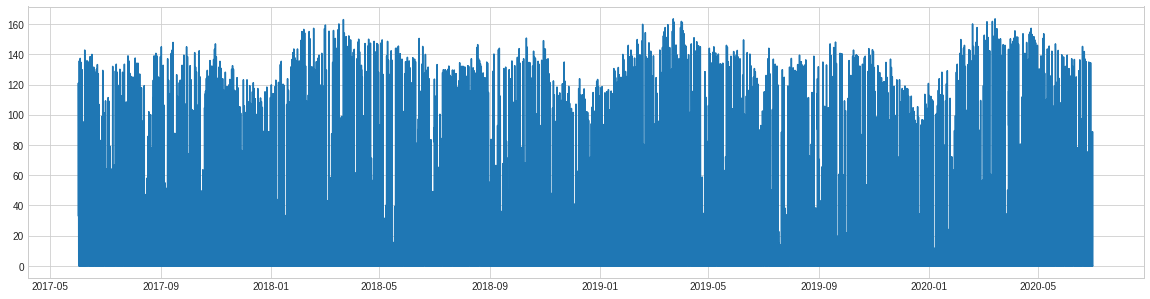

In [8]:
plt.figure(figsize=(20,5))
plt.plot(dataset['solar_result'])
plt.show()

Seasonal decomposition plot : Seasonal decomposition using moving average
https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

*   Observed : observed data
*   Trend : The estimated trend component
*   Seasonal : The estimated seasonal component
*   resid : The estimated residuals

[시계열분해법](https://leedakyeong.tistory.com/entry/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%ED%95%B4%EB%9E%80Time-Series-Decomposition-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%EC%84%9D%EC%9D%B4%EB%9E%80-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%9E%80-%EC%B6%94%EC%84%B8Trend-%EC%88%9C%ED%99%98Cycle-%EA%B3%84%EC%A0%88%EC%84%B1Seasonal-%EB%B6%88%EA%B7%9C%EC%B9%99-%EC%9A%94%EC%86%8CRandom-Residual)


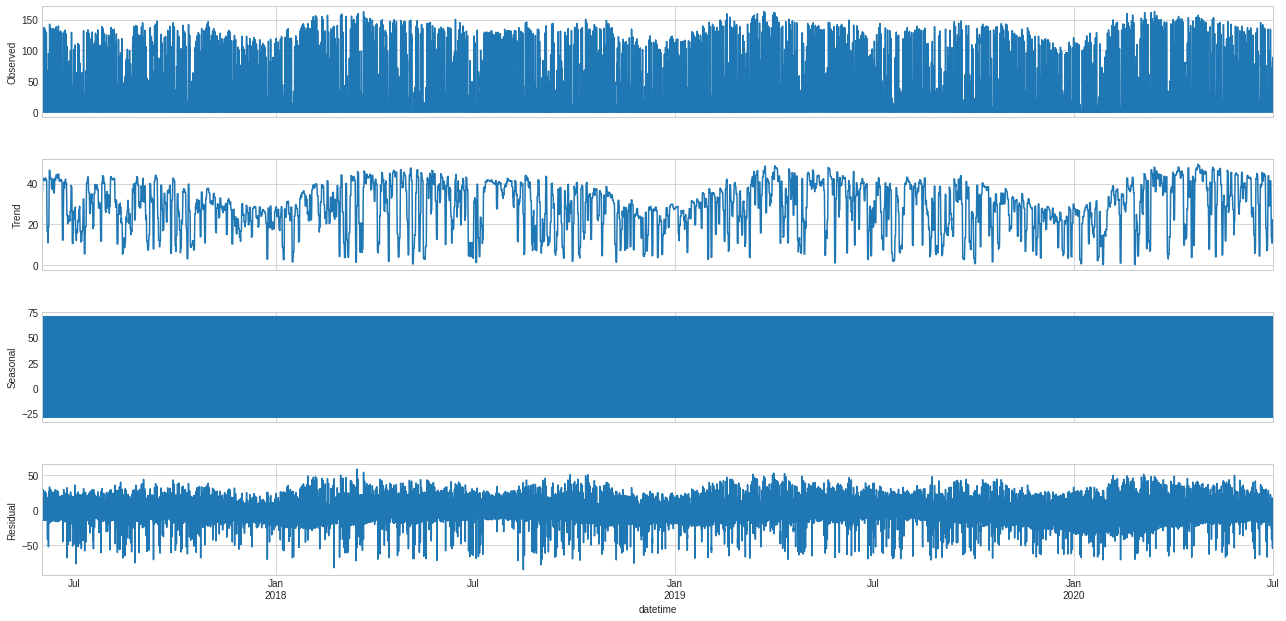

In [9]:
# decompotion = sm.tsa.seasonal_decompose(dataset['solar_result'], model='additive', period =1)

# decompotion = seasonal_decompose(dataset['solar_result'], model='additive', period =1)
# # TypeError: seasonal_decompose() got an unexpected keyword argument 'period'

decompotion = seasonal_decompose(dataset['solar_result'], model='additive')
fig = decompotion.plot()
fig.set_size_inches(20,10)
plt.show()

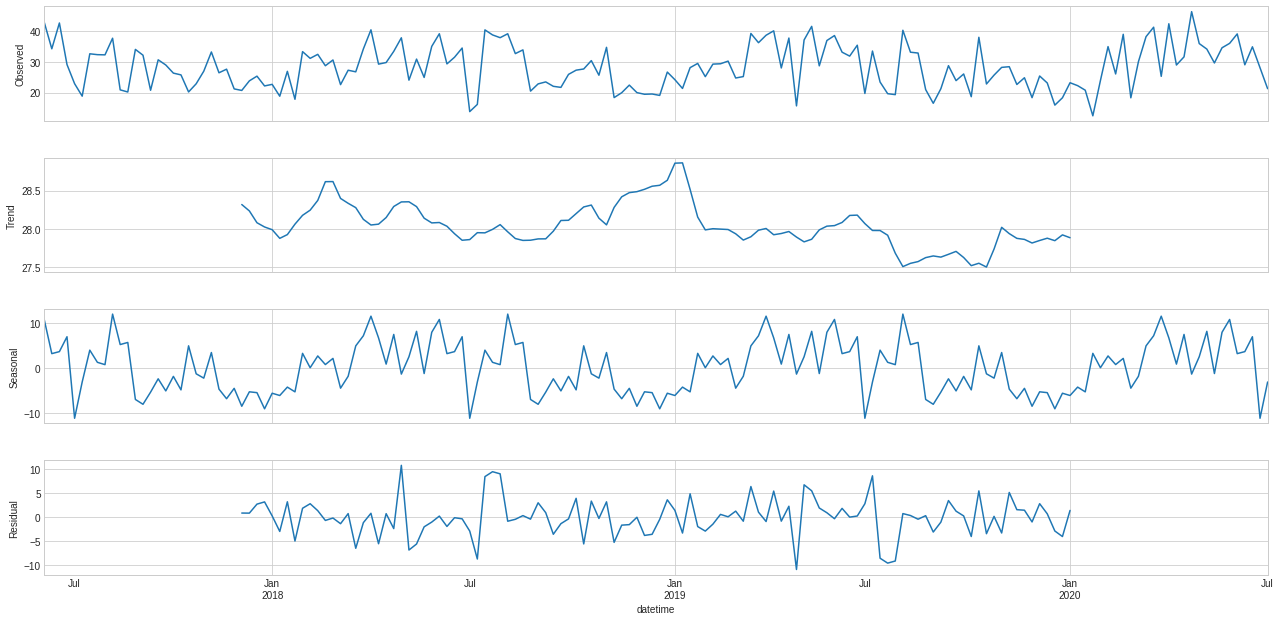

In [10]:
# seasonal을 보고자 주단위로 그려봄

y = dataset['solar_result'].resample('W-MON').mean()
decompotion = seasonal_decompose(y, model='additive')
fig = decompotion.plot()
fig.set_size_inches(20,10)
plt.show()

###2.Identify Model to be Tentatively Entertainted

In [11]:
# Train:Test = 8:2
train_data = dataset[:'2019-05-31 23:00:00']
test_data = dataset['2019-06-01 00:00:00':]
train_data, test_data = train_test_split(dataset, test_size = 0.2, shuffle=False)

In [12]:
train_data

,solar_result
datetime,
2017-06-01 09:00:00,33.12
2017-06-01 10:00:00,50.16
2017-06-01 11:00:00,96.72
2017-06-01 12:00:00,120.96
2017-06-01 13:00:00,118.80
...,...
2019-11-18 16:00:00,7.44
2019-11-18 17:00:00,0.00
2019-11-18 18:00:00,0.00


ACF, PACF plot

https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

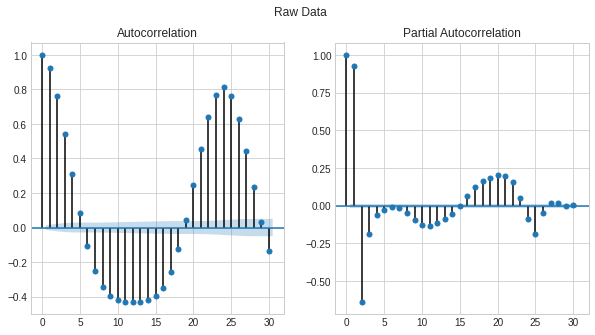

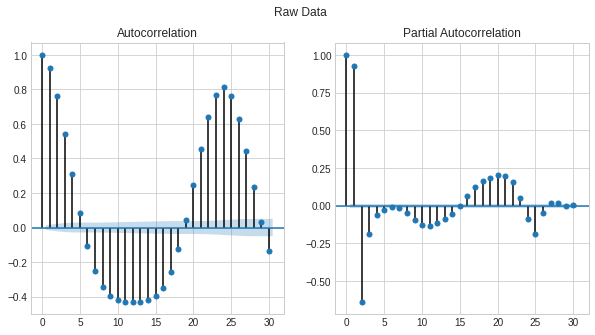

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0]) # 스퀴즈(Squeeze) - 1인 차원을 제거한다.
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])
# sm.graphics.tsa.plot_acf(train_data, lags=30, ax=ax[0])
# sm.graphics.tsa.plot_pacf(train_data, lags=30, ax=ax[1])

# Q) 왜 그래프가 두개나 나오지?
# 결과는 소멸하는 sin함수 형태로서 AR모델이랑 잘맞는 모델로서 나옴

Differencing
차분 : 현 시점 데이터에서 d시점 이전 데이터를 뺀 것

In [14]:
# diff_train_data = train_data.copy()
# diff_train_data = diff_train_data['solar_result'].diff() # 차분 default 값 1임
# diff_train_data = diff_train_data.dropna() # 차분을 하다보면 마지막 값의 경우 길이가 맞지 않아서 결측치가 발생되는데 이러한 부분이 계속 남아있으면 예측이 잘 안되므로 결측치 제거
# print('###### Raw Data ######')
# print(train_data)
# print('### Differenced Data ###')
# print(diff_train_data)

# # 차분 결과 aic가 너무 높게 나와서 차분은 생략

In [15]:
# # Differenced data plot

# plt.figure(figsize=(12,8))
# plt.subplot(211)
# plt.plot(train_data['solar_result'])
# plt.legend(['Raw Data (Nonstationary)'])
# plt.subplot(212)
# plt.plot(diff_train_data, 'orange') # first difference (t - (t-1))
# plt.legend(['Differenced Data (Stationary)'])
# plt.show()

# # 차분 결과 aic가 너무 높게 나와서 차분은 생략

In [16]:
# # ACF, PACF plot
# fig, ax = plt.subplots(1,2,figsize=(10,5))
# fig.suptitle('Raw Data')
# sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0]) # 스퀴즈(Squeeze) - 1인 차원을 제거한다.
# sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

#  # 차분 결과 aic가 너무 높게 나와서 차분은 생략

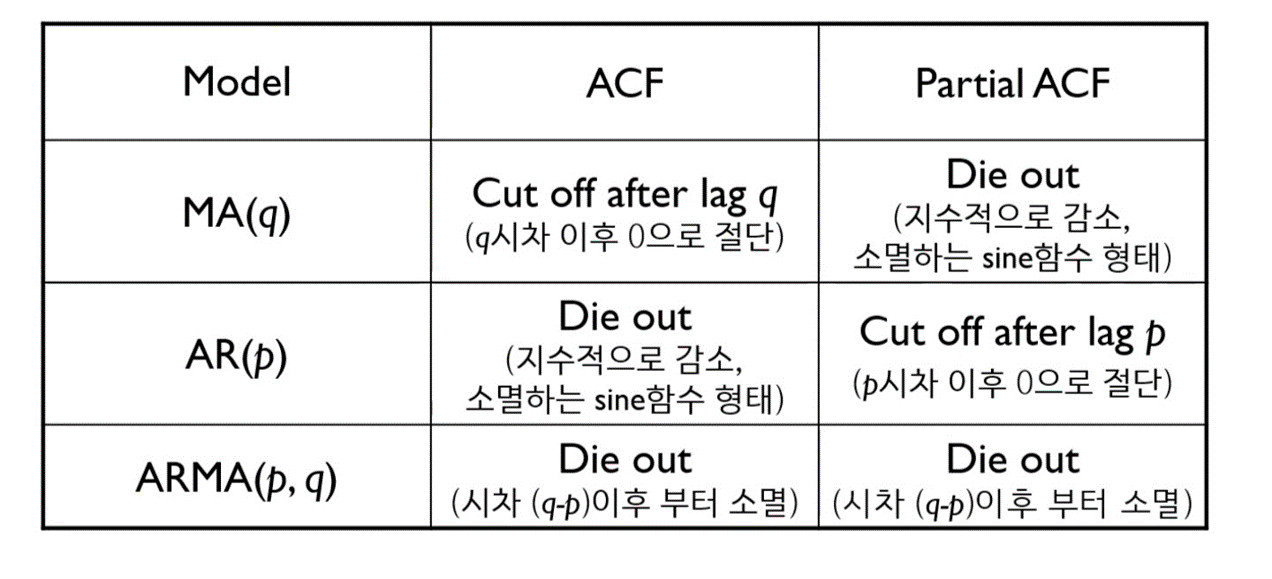

###3.Estimate parameter

In [17]:
# ARIMA model fitting
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

model = ARIMA(train_data.values, order=(1,0,0))
model_fit = model.fit()
model_fit.summary()

# Q1) AIC score 17만?? 이렇게 커도 되나?
# Q2) 차분 안할시 AIC score 18만?? 이렇게 커도 되나?

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                21612
Model:                     ARMA(1, 0)   Log Likelihood              -91167.692
Method:                       css-mle   S.D. of innovations             16.435
Date:                Tue, 17 Aug 2021   AIC                         182341.384
Time:                        07:08:43   BIC                         182365.327
Sample:                             0   HQIC                        182349.188
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.1570      1.461     19.272      0.000      25.293      31.021
ar.L1.y        0.9235      0.003    354.164      0.000       0.918       0.929
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0828           +0.0000j            1.0828            0.0000
-----------------------------------------------------------------------------
"""

##4.ARIMA

Diagonisis check

In [18]:
## 파라미터 최적화 하고 싶을 시 활성화 
# # Parameter search

# print('Examples of parameter combination for Seasonal ARIMA')
# p = range(0, 3)
# d = range(1, 2)
# q = range(0, 3)
# pdq = list(itertools.product(p,d,q))

# aic = []
# params=[] # optimal parameter순서 맞추려고 추가함
# for i in pdq:
#   try:
#     model = ARIMA(train_data.values, order = (i))
#     model_fit = model.fit()
#     print(f'ARIMA : {i} >> AIC : {round(model_fit.aic, 2)}')
#     aic.append(round(model_fit.aic,2))
#     params.append(i) # optimal parameter순서 맞추려고 추가함
#   except:
#     continue

#     # order = (2,1,1) 인 경우 계산이 안되어 예외처리함

In [19]:
# Search optimal parameters 

# optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
# optimal
optimal =  [((2, 1, 2), 170113.34)] ## 파라미터 최적화 하고 싶을 시 이 부분 주석 나머지 활성화 

In [20]:
model_opt = ARIMA(train_data.values, order = optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                21611
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -85050.671
Method:                       css-mle   S.D. of innovations             12.385
Date:                Tue, 17 Aug 2021   AIC                         170113.343
Time:                        07:09:02   BIC                         170161.228
Sample:                             1   HQIC                        170128.951
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.439      0.661      -0.002       0.001
ar.L1.D.y      1.6956      0.006    292.991      0.000       1.684       1.707
ar.L2.D.y     -0.8075      0.005   -148.068      0.000      -0.818      -0.797
ma.L1.D.y     -1.3222      0.009   -143.596      0.000      -1.340      -1.304
ma.L2.D.y      0.3231      0.009     35.085      0.000       0.305       0.341
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0500           -0.3688j            1.1129           -0.0538
AR.2            1.0500           +0.3688j            1.1129            0.0538
MA.1            1.0014           +0.0000j            1.0014            0.0000
MA.2            3.0902           +0.0000j            3.0902            0.0000
-----------------------------------------------------------------------------
"""

use Model to forecast

In [21]:
prediction = model_opt_fit.forecast(len(test_data))
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.forecast.html#statsmodels.tsa.arima_model.ARIMAResults.forecast

In [22]:
test_data['ARIMA'] = prediction[0]

In [23]:
test_data

,solar_result,ARIMA
datetime,,
2019-11-18 21:00:00,0.0,3.952753
2019-11-18 22:00:00,0.0,9.585211
2019-11-18 23:00:00,0.0,15.943943
2019-11-19 00:00:00,0.0,22.177856
2019-11-19 01:00:00,0.0,27.613682
...,...,...
2020-06-30 20:00:00,0.0,23.965994
2020-06-30 21:00:00,0.0,23.965659
2020-06-30 22:00:00,0.0,23.965324


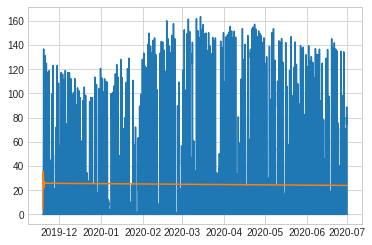

In [24]:
plt.plot(test_data)

##5.SARIMA

In [26]:
model_SARIMA_12 = SARIMAX(train_data.values, order=(2, 1, 2), seasonal_order=(1,0,0,12))
model_SARIMA_12_fit = model_SARIMA_12.fit()
model_SARIMA_12_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                21612
Model:             SARIMAX(2, 1, 2)x(1, 0, 0, 12)   Log Likelihood              -85050.766
Date:                            Tue, 17 Aug 2021   AIC                         170113.531
Time:                                    07:09:41   BIC                         170161.417
Sample:                                         0   HQIC                        170129.139
                                          - 21612                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6958      0.005    312.026      0.000       1.685       1.706
ar.L2         -0.8076      0.005   -152.212      0.000      -0.818      -0.797
ma.L1         -1.3224      0.007   -179.515      0.000      -1.337      -1.308
ma.L2          0.3233      0.007     44.003      0.000       0.309       0.338
ar.S.L12       0.0005      0.017      0.029      0.977      -0.032       0.033
sigma2       153.3890      0.813    188.758      0.000     151.796     154.982
===================================================================================
Ljung-Box (Q):                     5048.38   Jarque-Bera (JB):             48674.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# for i in range(12,121):
#   try:
#     model = SARIMAX(train_data.values, order=(2, 1, 2), seasonal_order=(0,0,0,i))
#     model_fit = model.fit()
#     print(f'SARIMA : (2,1,2), (0,0,0,{i}) >> AIC : {round(model_fit.aic,2)}')
#     model_fit.summary()
#     params.append((2,1,2),(0,0,0,{i}))
#   except:
#     continue

## 결과 : seasonal 기간 최적화를 하려했으나 너무 오래걸림

In [33]:
model_SARIMA = SARIMAX(train_data.values, order=(2, 1, 2), seasonal_order=(1,0,0,24)) # SARIMA 태양광 예측 parameter 기준
model_SARIMA_fit = model_SARIMA.fit()
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                21612
Model:             SARIMAX(2, 1, 2)x(1, 0, 0, 24)   Log Likelihood              -83496.920
Date:                            Tue, 17 Aug 2021   AIC                         167005.839
Time:                                    07:15:06   BIC                         167053.725
Sample:                                         0   HQIC                        167021.447
                                          - 21612                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6676      0.008    202.473      0.000       1.651       1.684
ar.L2         -0.7682      0.008    -98.963      0.000      -0.783      -0.753
ma.L1         -1.5043      0.010   -148.683      0.000      -1.524      -1.484
ma.L2          0.5047      0.010     49.917      0.000       0.485       0.525
ar.S.L24       0.4288      0.004    110.016      0.000       0.421       0.436
sigma2       132.7988      0.639    207.735      0.000     131.546     134.052
===================================================================================
Ljung-Box (Q):                     2630.26   Jarque-Bera (JB):             60094.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
prediction_SARIMA = model_SARIMA_fit .forecast(len(test_data))

In [35]:
test_data['SARIMA'] = prediction_SARIMA[0]

In [36]:
test_data

,solar_result,ARIMA,SARIMA
datetime,,,
2019-11-18 21:00:00,0.0,3.952753,2.147266
2019-11-18 22:00:00,0.0,9.585211,2.147266
2019-11-18 23:00:00,0.0,15.943943,2.147266
2019-11-19 00:00:00,0.0,22.177856,2.147266
2019-11-19 01:00:00,0.0,27.613682,2.147266
...,...,...,...
2020-06-30 20:00:00,0.0,23.965994,2.147266
2020-06-30 21:00:00,0.0,23.965659,2.147266
2020-06-30 22:00:00,0.0,23.965324,2.147266


In [37]:
import plotly.graph_objects as go

f = go.FigureWidget()
set_period = test_data['2020-05-01 00:00:00':]
f.update_layout(plot_bgcolor='white')
f.add_scatter(y=set_period['solar_result'],x = set_period.index, name = 'Real result');
f.add_scatter(y=set_period['ARIMA'],x = set_period.index, name = 'ARIMA');
f.add_scatter(y=set_period['SARIMA'],x = set_period.index, name = 'SARIMA');
f.show()